In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
from keras.utils import np_utils

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Conv3D, MaxPool3D, Conv2D, Conv1D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, Average
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import layers
from keras import Model, Input

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from config.utils import *
from config.models import *

import spectral
from operator import truediv

In [2]:
print(tf.__version__)

<IPython.core.display.Javascript object>

2.3.1


In [3]:
######### GLOBAL PARAMETERS #########
dataset = 'IP'
testSize = 0.3
windowSize = 25

K = 30 if dataset == 'IP' else 15

PATH1 = 'saved_models/' + dataset + '/' + 'first' + dataset + '.hdf5'
PATH2 = 'saved_models/' + dataset + '/' + 'second' + dataset + '.hdf5'
######### GLOBAL PARAMETERS #########

In [4]:
input_shape = (25,25,K,1)
model_input = Input(shape=input_shape)

In [5]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = keras.layers.Average()(outputs)
    model = Model(model_input, y)
    return model

In [6]:
def ensemble_try(models, X_Test):
    
    Y_Pred = [model.predict(X_Test) for model in models]
    Y_Pred = np.array(Y_Pred)
    #print('Before Summed Shape - ', Y_Pred.shape)
    summed = np.sum(Y_Pred, axis = 0)
    #print('After Summed Shape - ', Y_Pred.shape)
    result = np.argmax(summed, axis=1)
    
    return result

In [7]:
X, Y = loadData(dataset)
units, target_names = targets(dataset)

X,pca = applyPCA(X,N=30)
ev=pca.explained_variance_ratio_
print('X.shape',X.shape)
print('y.shape',Y.shape)

X , Y = createImageCubes(X,Y,windowSize=windowSize)

X_Train , X_Test , Y_Train, Y_Test = train_test_split(X,Y,test_size=testSize,random_state=345)

Y_Train = np_utils.to_categorical(Y_Train)
Y_Test = np_utils.to_categorical(Y_Test)

X_Train = X_Train.reshape(-1, windowSize, windowSize, K, 1)
X_Test = X_Test.reshape(-1, windowSize, windowSize,K, 1)

X.shape (145, 145, 30)
y.shape (145, 145)


In [8]:
Hybrid1 = make_3d_1(units, dataset)
Hybrid2 = make_3d_2(units, dataset)

for layers in Hybrid1.layers:
    layers.trainable = True

for layers in Hybrid2.layers:
    layers.trainable = True
    
adam = Adam(lr=0.001, decay=1e-06)
Hybrid1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
Hybrid2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Hybrid1.load_weights(PATH1)
Hybrid2.load_weights(PATH2)

models = [Hybrid1, Hybrid2]

In [9]:
loss_val, acc_val = Hybrid1.evaluate(X_Test, Y_Test, verbose=1)

97/97 [==============================] - 6s 65ms/step - loss: 0.7237 - accuracy: 0.9353


In [10]:
loss_val, acc_val = Hybrid2.evaluate(X_Test, Y_Test, verbose=1)

97/97 [==============================] - 8s 79ms/step - loss: 0.2939 - accuracy: 0.9180


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

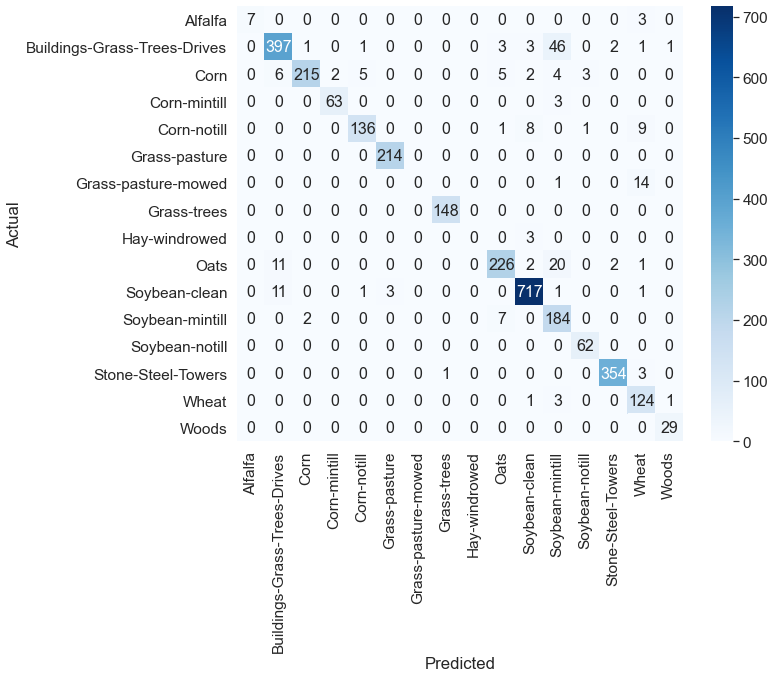

In [26]:
Y_Pred = Hybrid1.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

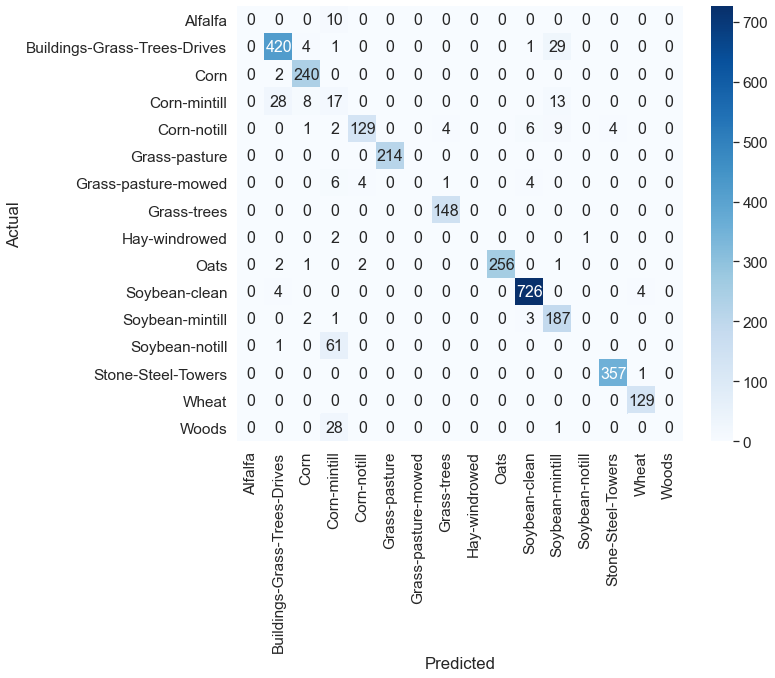

In [27]:
Y_Pred = Hybrid2.predict(X_Test)
Y_Pred = np.argmax(Y_Pred, axis=1)

Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))

df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')
#plt.savefig('cmap_IP_first_model.png', dpi=300)

In [11]:
Hybrid1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 23, 23, 26, 8)     368       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 24, 16)    3472      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 10, 12, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 12, 16)    64        
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 192)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          110656    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [12]:
Hybrid2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 19, 19, 18, 16)    6928      
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 17, 17, 16, 16)    6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 16, 16)    64        
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)       

In [13]:
Y_Pred = ensemble_try(models, X_Test)
Y_Pred.shape

(3075,)

In [14]:
Report = (classification_report(np.argmax(Y_Test, axis=1), Y_Pred, target_names=target_names))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print(Report)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.60      0.75        10
                 Corn-notill       0.98      0.92      0.95       455
                Corn-mintill       0.97      0.99      0.98       242
                        Corn       1.00      0.86      0.93        66
               Grass-pasture       0.99      0.92      0.95       155
                 Grass-trees       1.00      1.00      1.00       214
         Grass-pasture-mowed       0.00      0.00      0.00        15
               Hay-windrowed       0.98      1.00      0.99       148
                        Oats       0.00      0.00      0.00         3
              Soybean-notill       0.98      0.98      0.98       262
             Soybean-mintill       0.99      0.99      0.99       734
               Soybean-clean       0.82      0.96      0.89       193
                       Wheat       0.98      1.00      0.99        62
                   

In [16]:
Matrix = (confusion_matrix(np.argmax(Y_Test, axis=1), Y_Pred))
print(Matrix)

[[  6   0   0   0   0   0   0   0   0   0   0   0   0   0   4   0]
 [  0 419   4   0   0   0   0   0   0   0   1  31   0   0   0   0]
 [  0   2 240   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   2  57   0   0   0   0   0   0   0   6   0   0   0   0]
 [  0   0   0   0 142   0   0   3   0   0   6   0   1   2   1   0]
 [  0   0   0   0   0 214   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   1   0   0  13   0]
 [  0   0   0   0   0   0   0 148   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0]
 [  0   1   0   0   1   0   0   0   0 258   0   1   0   1   0   0]
 [  0   4   0   0   0   0   0   0   0   0 729   0   0   0   1   0]
 [  0   0   2   0   0   0   0   0   0   5   0 186   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  62   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 357   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0 128 

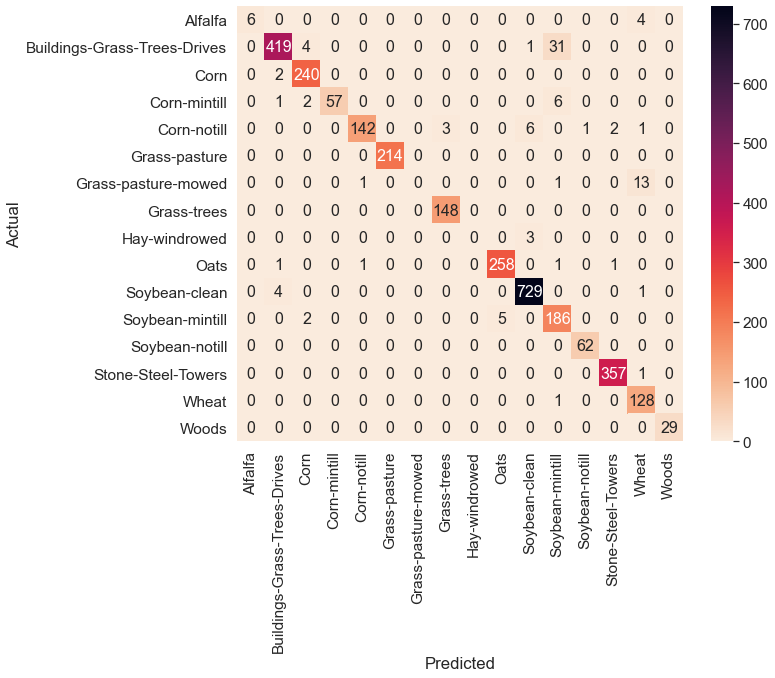

In [25]:
df_cm = pd.DataFrame(Matrix, columns=np.unique(target_names), index = np.unique(target_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="rocket_r", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap_IP_ensemble_model.png', dpi=300)

In [18]:
X, Y = loadData(dataset)

height = Y.shape[0]
width = Y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [19]:
X,pca = applyPCA(X, numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

In [20]:
outputs = np.zeros((height,width))

for i in range(height):
    for j in range(width):
        target = int(Y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j,PATCH_SIZE)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (ensemble_try(models, X_test_image))
            #prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

C:\ProgramData\Anaconda3\lib\site-packages\spectral\graphics\spypylab.py:904: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


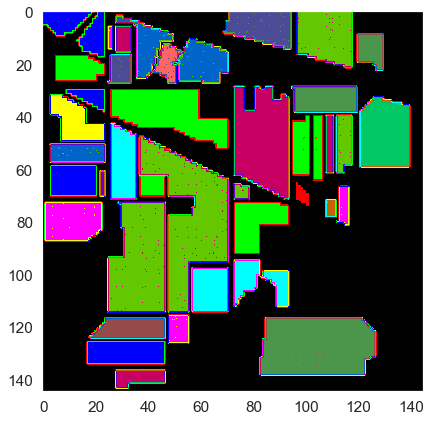

In [21]:
ground_truth = spectral.imshow(classes = Y,figsize =(7,7))

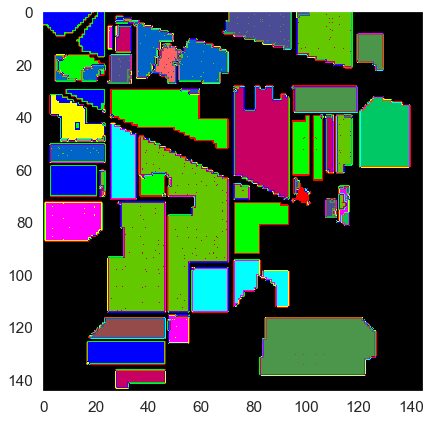

In [22]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [23]:
spectral.save_rgb("predictions_ip.jpg", outputs.astype(int), colors=spectral.spy_colors)